In [1]:
# import required libraries
import numpy as np
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Dense, Flatten, concatenate, Dropout
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
from keras.applications import VGG16, ResNet50, InceptionV3
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, Rescaling
from tensorflow.keras import Input 
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Cell.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  #print('Done')

extracted_file_path = "/content/drive/MyDrive/Cell" 

In [4]:
# Defining Image Data Gen
WIDTH = 130
HEIGHT = 130 
BATCH_SIZE = 32
num_classes = 2
input_shape = (WIDTH, HEIGHT, 3)
train_datagen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              rescale=1/225,
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest',
                              validation_split=0.2)

In [5]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/cell_images/cell_images',
  validation_split=0.2,
  color_mode = "rgb",
  subset="validation",
  seed=69,
  image_size=(WIDTH, HEIGHT),
  batch_size=BATCH_SIZE)

Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


In [7]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/cell_images/cell_images',
  validation_split=0.2,
  color_mode = "rgb",
  subset="training",
  seed=69,
  image_size=(WIDTH, HEIGHT),
  batch_size=BATCH_SIZE)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.


In [8]:
# find how many batches are in val_data
val_batches = tf.data.experimental.cardinality(val_data)
test_data = val_data.take(val_batches // 2)
val_data = val_data.skip(val_batches // 2)

In [9]:
# performance boosting code --> prefetching 

AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

In [10]:
# applying data augmentation
data_augmentation = tf.keras.Sequential(
[
  RandomFlip('horizontal'),
  RandomRotation(0.25),
], "Augmentation_Layers")

In [11]:
# scale the inputs to between -1 to 1 
rescale = Rescaling(scale=1./127.5, offset=-1)

inputs = tf.keras.Input(shape=(WIDTH, HEIGHT, 1))
x = data_augmentation(inputs)
x = rescale(x)


In [12]:
x = tf.keras.layers.Lambda(lambda image: tf.image.grayscale_to_rgb(image))(x)
x = tf.keras.layers.Resizing(224, 224)(x)

In [15]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Lambda, Input
# Define input tensor
x = Input(shape=input_shape)

# Convert grayscale image to RGB image
if input_shape[-1] == 1:
    x = Lambda(lambda image: tf.image.grayscale_to_rgb(image))(x)

# Resize image
x = tf.keras.layers.Resizing(224, 224)(x)

# Add VGG19 base model
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=x)

# Add a pooling layer, dense layer, and output layer on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])



In [16]:
epochs = 10
early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
history = model.fit(train_data,
                    epochs=epochs,
                    validation_data=val_data, callbacks=[early_stop])

Epoch 1/10
689/689 [==============================] - 302s 407ms/step - loss: 1.2153 - accuracy: 0.4990 - val_loss: 0.6931 - val_accuracy: 0.5143
Epoch 2/10
689/689 [==============================] - 272s 394ms/step - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.5107
Epoch 3/10
689/689 [==============================] - 272s 394ms/step - loss: 0.6932 - accuracy: 0.4963 - val_loss: 0.6931 - val_accuracy: 0.5136
Epoch 4/10
689/689 [==============================] - 272s 395ms/step - loss: 0.6932 - accuracy: 0.4954 - val_loss: 0.6931 - val_accuracy: 0.5147


In [17]:
model.evaluate(test_data)

86/86 [==============================] - 10s 114ms/step - loss: 0.6931 - accuracy: 0.5015


[0.6931423544883728, 0.5014534592628479]

In [18]:
val_loss=history.history['val_loss']
train_loss=history.history['loss']

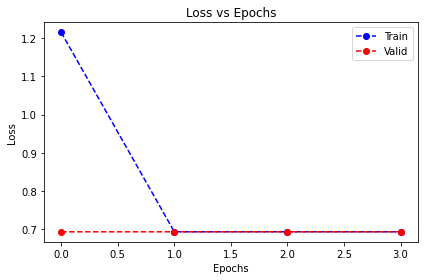

In [19]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss,'bo--')
plt.plot(val_loss,'ro--')
plt.title('Loss vs Epochs')
plt.legend(['Train','Valid'])
plt.tight_layout()
plt.show()

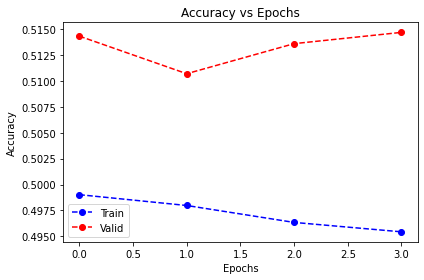

In [20]:
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.epoch, history.history['accuracy'],'bo--')
plt.plot(history.epoch, history.history['val_accuracy'],'ro--')
# plt.plot(train_loss,'bo--')
# plt.plot(val_loss,'ro--')
plt.title('Accuracy vs Epochs')
plt.legend(['Train','Valid'])
plt.tight_layout()
plt.show()

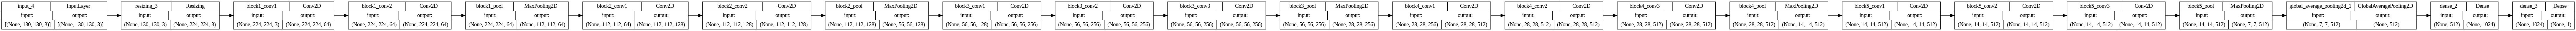

In [21]:
tf.keras.utils.plot_model(model,show_shapes=True,rankdir='LR')

In [22]:
 from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report  
results = confusion_matrix 
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',history.history['accuracy'] )
print ('Report : ')
print (history.history['val_accuracy']) 

Confusion Matrix :
<function confusion_matrix at 0x7f759b74d280>
Accuracy Score : [0.49902480840682983, 0.49798157811164856, 0.49634870886802673, 0.4954415559768677]
Report : 
[0.5143167972564697, 0.510692298412323, 0.5135918855667114, 0.5146792531013489]


In [23]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
# Make predictions on the test data
y_pred = model.predict(test_data)
y_pred = np.round(y_pred).flatten()

# Obtain the true labels for the test data
y_true = np.concatenate([y for x, y in test_data], axis=0)
y_true = y_true.flatten()

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)



86/86 [==============================] - 10s 113ms/step
[[   0 1383]
 [   0 1369]]


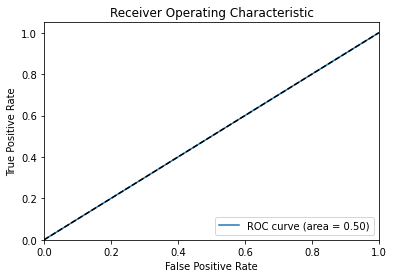

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [26]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])

# Print the classification report
print(report)


              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00      1383
     Class 1       0.50      1.00      0.66      1369

    accuracy                           0.50      2752
   macro avg       0.25      0.50      0.33      2752
weighted avg       0.25      0.50      0.33      2752



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
